In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tifffile as tiff
from skimage.transform import resize
import joblib


chosen_folder = input("Enter the folder name (e.g., 'Dry Weather' or 'Monsoon'): ")

# Load CSV data
csv_file = r"C:\Users\Lenovo\Downloads\SIH_data_withdischarge.csv"
data = pd.read_csv(csv_file)


data['Image Name'] = data['Image Name'].str.extract(r'(\d{4}-\d{2}-\d{2})')


base_image_directory = os.path.join(r"E:\Sorted_Dataset", chosen_folder)


target_size = (224, 224)


def preprocess_image(image_path):
    try:

        img = tiff.imread(image_path)


        img_resized = resize(img, target_size, anti_aliasing=True)



        return img_resized
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None


X = []
y = []
c =0
for filename in os.listdir(base_image_directory):
    if filename.endswith('.tif'):

        image_path = os.path.join(base_image_directory, filename)


        img_array = preprocess_image(image_path)

        if img_array is not None:

            image_name = filename.split('.')[0]

            matching_record = data[data['Image Name'] == image_name]
            if not matching_record.empty:
                c= c+1
                discharge_value = matching_record['Discharge'].values[0]
                X.append(img_array)
                y.append(discharge_value)
print(f"Total NonEmpty records are {c}")
X = np.array(X)
y = np.array(y)


scaler = MinMaxScaler()
y_normalized = scaler.fit_transform(y.reshape(-1, 1))


X_train, X_test, y_train, y_test = train_test_split(X, y_normalized, test_size=0.2, random_state=42)


model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2], X.shape[3])),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1)
])


model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


mse, mae = model.evaluate(X_test, y_test)
print(f'Mean Squared Error: {mse}, Mean Absolute Error: {mae}')


model.save(f'{chosen_folder.lower().replace(" ", "_")}_sar_model.h5')
joblib.dump(scaler, f'{chosen_folder.lower().replace(" ", "_")}_discharge_scaler.pkl')


In [3]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 28.0 MB/s eta 0:00:00


In [2]:
!pip install imagecodecs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 17.4 MB/s eta 0:00:00


Enter the weather condition ('monsoon' or 'dry_weather'): monsoon
Enter the discharge value: 3000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Path to closest image for Target Discharge: /content/drive/MyDrive/Grand Finale Dataset/Sorted_Dataset/Monsoon/2017-09-09.tif
1/1 [==============================] - 0s 153ms/step


<ipython-input-2-153adfa2987b>:80: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (224, 224, 3) looks like that of an RGB image.
  threshold_value = threshold_otsu(smoothed_image)


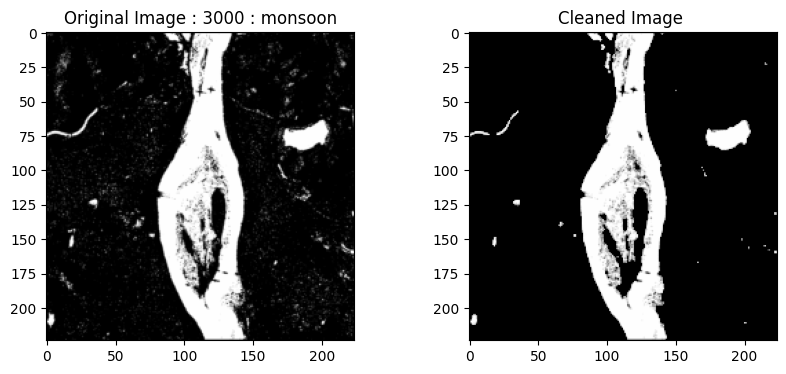

Closest Image Name: 2017-09-09
Closest Discharge Value: 3024.0
Cleaned image saved successfully at: /content/drive/MyDrive/Grand Finale Dataset/Sorted_Dataset/monsoon_cleaned_images/cleaned_image_discharge_3024.tif


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import tifffile as tiff
from skimage.transform import resize
from skimage.filters import gaussian
import joblib
import matplotlib.pyplot as plt
import rasterio
from scipy.ndimage import median_filter
from skimage.filters import threshold_otsu

weather_condition = input("Enter the weather condition ('monsoon' or 'dry_weather'): ")
discharge_value = int(input("Enter the discharge value: "))

csv_file=""
if weather_condition == "monsoon":
    csv_file = r"/content/drive/MyDrive/Grand Finale Dataset/Sorted_Dataset/SIH_monsoon_data.csv"
elif weather_condition == "dry_weather":
    csv_file = r"/content/drive/MyDrive/Grand Finale Dataset/Sorted_Dataset/SIH_dry_weather_data.csv"
else:
    print("Invalid weather condition. Exiting.")
    exit()
data = pd.read_csv(csv_file)


target_size = (224, 224)


def preprocess_image(image_path, target_size):
    try:
        img = tiff.imread(image_path)
        img_resized = resize(img, target_size, anti_aliasing=True)
        return img_resized
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

def clean_image(input_image, ideal_image, density_threshold=0.2, post_process=True):
    cleaned_image = np.copy(input_image)


    if len(ideal_image.shape) == 2:

        pixel_density_threshold = np.max(ideal_image) * density_threshold


        main_river_stream = input_image >= pixel_density_threshold


        cleaned_image[~main_river_stream] = 0
    else:

        for c in range(input_image.shape[2]):

            pixel_density_threshold = np.max(ideal_image[:, :, c]) * density_threshold


            main_river_stream = input_image[:, :, c] >= pixel_density_threshold


            cleaned_image[~main_river_stream, c] = 0


    if post_process:
        cleaned_image = post_process_image(cleaned_image)

    return cleaned_image

def post_process_image(cleaned_image):

    smoothed_image = np.zeros_like(cleaned_image)
    for c in range(3):
        smoothed_image[:, :, c] = median_filter(cleaned_image[:, :, c], size=3)


    threshold_value = threshold_otsu(smoothed_image)
    binary_mask = smoothed_image > threshold_value


    cleaned_image_post_processed = cleaned_image * binary_mask

    return cleaned_image_post_processed



if weather_condition == "monsoon":
    base_image_directory = r"/content/drive/MyDrive/Grand Finale Dataset/Sorted_Dataset/Monsoon"
    output_tiff_directory = r"/content/drive/MyDrive/Grand Finale Dataset/Sorted_Dataset/monsoon_cleaned_images"
elif weather_condition == "dry_weather":
    base_image_directory = r"/content/drive/MyDrive/Grand Finale Dataset/Sorted_Dataset/Dry Weather"
    output_tiff_directory = r"/content/drive/MyDrive/Grand Finale Dataset/Sorted_Dataset/dry_weather_cleaned_images"
else:
    print("Invalid weather condition. Exiting.")
    exit()


if weather_condition == "monsoon":
    model_path = r"/content/drive/MyDrive/Grand Finale Dataset/Sorted_Dataset/monsoon_sar_model.h5"
    scaler_path = r"/content/drive/MyDrive/Grand Finale Dataset/Sorted_Dataset/monsoon_discharge_scaler.pkl"
else:
    model_path = r"/content/drive/MyDrive/Grand Finale Dataset/Sorted_Dataset/dry_weather_sar_model.h5"
    scaler_path = r"/content/drive/MyDrive/Grand Finale Dataset/Sorted_Dataset/dry_weather_discharge_scaler.pkl"

loaded_model = keras.models.load_model(model_path)
loaded_scaler = joblib.load(scaler_path)

data.columns = data.columns.str.strip()


scaler = MinMaxScaler()
y = scaler.fit_transform(data['Discharge'].values.reshape(-1, 1))


normalized_target_discharge = scaler.transform(np.array(discharge_value).reshape(1, -1))[0, 0]
closest_index = np.argmin(np.abs(y - normalized_target_discharge))
closest_discharge = scaler.inverse_transform(y[closest_index:closest_index+1])[0, 0]
closest_image_name = data.loc[closest_index, 'Image Name']

closest_image_name = closest_image_name.split(':')[-2].strip()

closest_image_path = os.path.join(base_image_directory, f"{closest_image_name}.tif")


print(f"Path to closest image for Target Discharge: {closest_image_path}")


target_image = preprocess_image(closest_image_path, target_size)


if target_image is None:
    print("Image could not be processed. Exiting.")
else:

    target_image = np.expand_dims(target_image, axis=0)


    predicted_discharge = loaded_model.predict(target_image)


    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(target_image[0], cmap='gray')
    plt.title(f'Original Image : {discharge_value} : {weather_condition}')

    plt.subplot(1, 2, 2)
    cleaned_image = clean_image(target_image[0], target_image[0])
    plt.imshow(cleaned_image, cmap='gray')
    plt.title(f'Cleaned Image ')

    plt.show()


    print(f"Closest Image Name: {closest_image_name}")
    print(f"Closest Discharge Value: {closest_discharge}")


    def save_tiff(image, discharge_value, output_directory, original_tif_path):
        try:

            os.makedirs(output_directory, exist_ok=True)


            discharge_value = int(discharge_value)


            output_filename = f"cleaned_image_discharge_{discharge_value}.tif"
            output_path = os.path.join(output_directory, output_filename)


            with rasterio.open(original_tif_path) as src:
                profile = src.profile
                transform = src.transform


                profile.update(
                    dtype=np.float32,
                    count=3,
                    photometric='rgb',
                    compress='deflate',
                )

                with rasterio.open(output_path, 'w', **profile) as dst:
                    dst.write(image.transpose(2, 0, 1).astype(np.float32))

            print(f"Cleaned image saved successfully at: {output_path}")
        except Exception as e:
            print(f"Error saving the cleaned image: {e}")


    original_tif_path = closest_image_path
    save_tiff(cleaned_image, closest_discharge, output_tiff_directory, original_tif_path)